DISCLAIMER: There is no way to make the text or word2vec part complete determinisitic as word2vec intializes randomly each time and uses stochastic gradient descent to train the model. We have tried to make it as reproducible as possible

In [1]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install nltk
!pip install gensim
!pip install scikit-learn
!pip install networkx
!pip install xgboost
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.4 MB/s eta 0:00:00


In [2]:
# package imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from sklearn.feature_selection import mutual_info_classif
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from functools import reduce
from nltk.tokenize import word_tokenize
from gensim.utils import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import operator
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import gensim
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import ParameterSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
#read in dataset and check read in properly
reviews_with_prod_label = pd.read_csv('electronics_with_prod_label.csv')
#drop nas, there are only six nas where the review title is missing, so we dropped them, as they will not affect the overall amount of data
reviews_with_prod_label = reviews_with_prod_label.dropna()
print(reviews_with_prod_label.head())
print(reviews_with_prod_label.columns)
print(reviews_with_prod_label.shape)

   review_rating  number_of_helpful  \
0            3.0                  1   
1            5.0                  1   
2            5.0                  0   
3            1.0                  1   
4            1.0                  4   

                                         review_body  \
0  Some of the functions did not work properly.  ...   
1  Corey Barker does a great job of explaining Bl...   
2  While many beginner DVDs try to teach you ever...   
3  It never worked. My daughter worked to earn th...   
4  Do not waste your money on this thing it is te...   

                                        review_title review_date  product_ID  \
0                                      Disappointing  2013-07-22  0439886341   
1                                      Very thorough  2013-04-13  0132793040   
2  Adobe Photoshop CS5 Crash Course with master P...  2012-07-01  0321732944   
3                                absolutely horrible  2013-04-29  0439886341   
4                     TERRIB

In [ ]:
#defining network and review features
network_features = ['pagerank', 'w_degree', 'clustering_coef', 'eigenvector_cent', 'degree', 'w_pagerank', 'w_clustering_coef', 'w_eigenvector_cent']

review_features = ['n_of_reviews','avg_review_rating',
                   'avg_days_between_reviews', 'stdev_days_between_reviews',
                   'max_days_between_reviews', 'min_days_between_reviews',
                   'avg_helpful_reviews', 'avg_1star_reviews', 'avg_5star_reviews', 'std_review_len']

In [ ]:
#Converting review date to a datetime format
reviews_with_prod_label['review_date'] = pd.to_datetime(reviews_with_prod_label['review_date'])

#sort dataframe by product id and within product id sort by review date (earliest to latest)
reviews_with_prod_label = reviews_with_prod_label.sort_values(['product_ID', 'review_date'])

#get days between reviews for each review in product group
#first group by product id, diff gets the difference between each row's review date and previous review data within the same product
#then extract the nubmer of days from result using dt.days
reviews_with_prod_label['days_between_reviews'] = (
    reviews_with_prod_label.groupby('product_ID')['review_date']
      .diff()
      .dt.days
)

#fill days between reviews for first review of product with 0 instead of NA
reviews_with_prod_label['days_between_reviews'] = reviews_with_prod_label['days_between_reviews'].fillna(0)

#concatenate review title with review body into one feature
reviews_with_prod_label["text"] = reviews_with_prod_label["review_title"].fillna("") + " " + reviews_with_prod_label["review_body"].fillna("")
#make all text lowercase
reviews_with_prod_label["text"] = reviews_with_prod_label["text"].apply(lambda x: x.lower())

In [ ]:
#obtain review features for each product by grouping reviews by product id, then aggregating other columns to get features
#ex. avg_review_rating comes from taking the mean of all of the reviews' ratings for each product
reviews_metadata = reviews_with_prod_label.groupby(["product_ID"]).agg(
    n_of_reviews = ('review_rating', 'count'),
    avg_review_rating = ('review_rating', 'mean'),
    avg_days_between_reviews = ('days_between_reviews', 'mean'),
    stdev_days_between_reviews = ('days_between_reviews', 'std'),
    max_days_between_reviews = ('days_between_reviews', 'max'),
    min_days_between_reviews = ('days_between_reviews', 'min'),
    avg_helpful_reviews = ('number_of_helpful', lambda x: (x > 0).mean()),
    avg_1star_reviews = ('review_rating', lambda x: (x == 1).mean()),
    avg_5star_reviews = ('review_rating', lambda x: (x == 5).mean()),
    std_review_len = ('text', lambda x: x.apply(lambda y: len(y.split())).std())
)

#removing all products where the number of reviews is one
reviews_metadata = reviews_metadata[reviews_metadata["n_of_reviews"] > 1]
#reset index
reviews_metadata = reviews_metadata.reset_index()
#add back in product id/fake label for each product
reviews_metadata = reviews_metadata.merge(reviews_with_prod_label, on='product_ID', how='left')
#remove duplicates of products, keep one instance of each product
reviews_metadata = reviews_metadata.drop_duplicates(subset=['product_ID'])
#keeping all columns related to metadata of reviews, with product id and label if buy fake reviews or not
reviews_metadata = reviews_metadata[['product_ID', 'n_of_reviews', 'avg_review_rating', 'avg_days_between_reviews', 'stdev_days_between_reviews', 'max_days_between_reviews', 'min_days_between_reviews', 'avg_helpful_reviews', 'avg_1star_reviews', 'avg_5star_reviews', 'std_review_len', 'fake']]

In [ ]:
def eda_plotting(data, column_title):
  #defining general plotting function for eda
  #filter the observations with fake label (products that buy fake reviews)
  fake_data = data[data["fake"] == 1]
  #filter the observations with real label (products that do not buy fake reviews)
  real_data = data[data["fake"] == 0]

  #create side by side subplots (so can have feature distribution under fake/real labels)
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  #create feature distribution plot for products that don't buy fake reviews
  real_data[column_title].hist(bins=20, ax=axes[0])
  axes[0].set_title(f"{column_title} for products that don't buy fake reviews", fontsize = 10)
  axes[0].set_xlabel(column_title)
  axes[0].set_ylabel("Count")
  #create feature distribution plot for products that buy fake reviews
  fake_data[column_title].hist(bins=20, ax=axes[1])
  axes[1].set_title(f"{column_title} for products that buy fake reviews", fontsize = 10)
  axes[1].set_xlabel(column_title)
  axes[1].set_ylabel("Count")
  plt.tight_layout()
  plt.show()

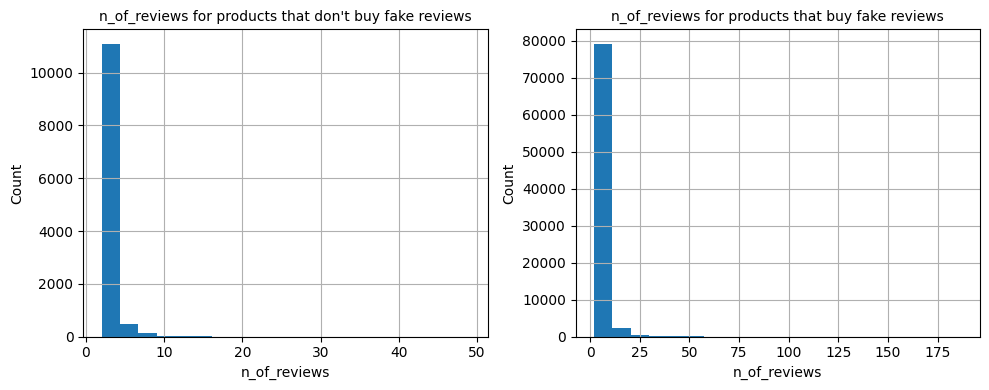

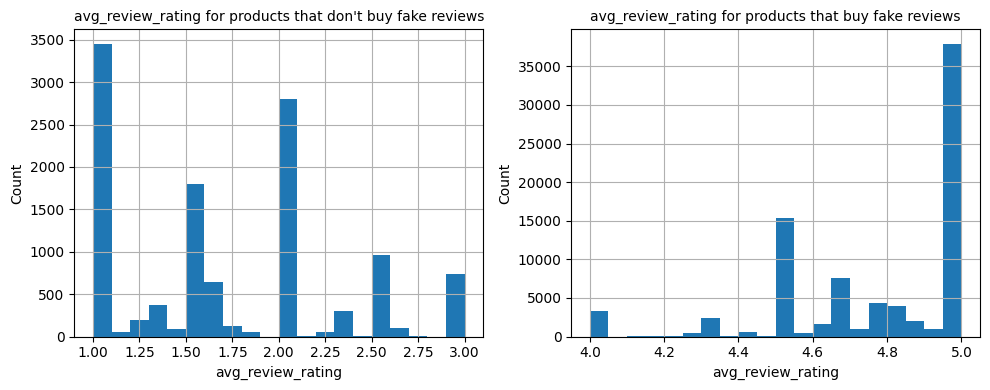

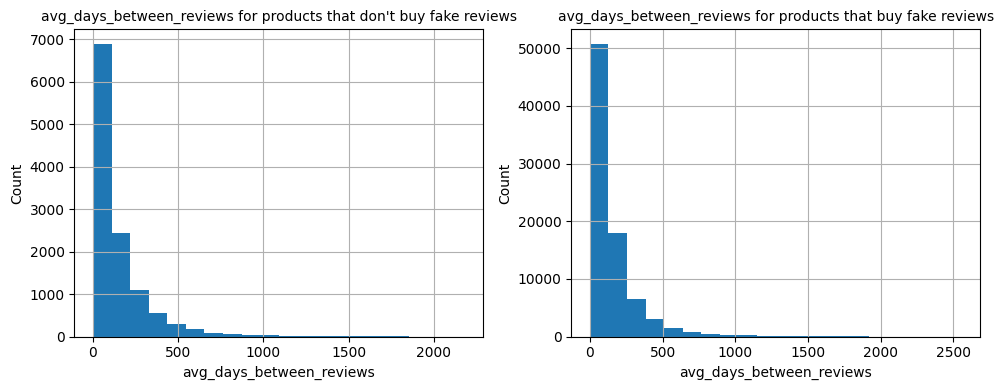

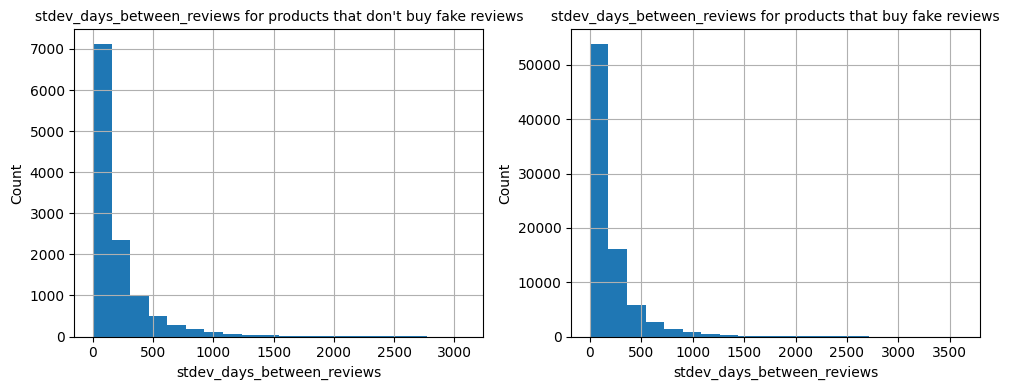

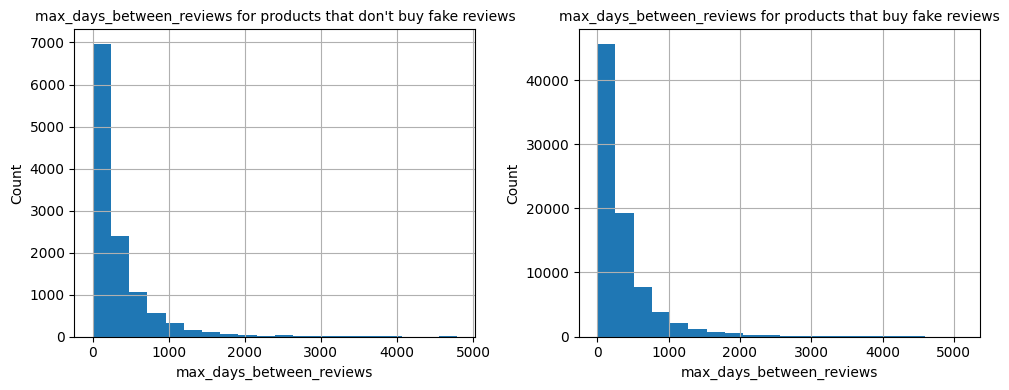

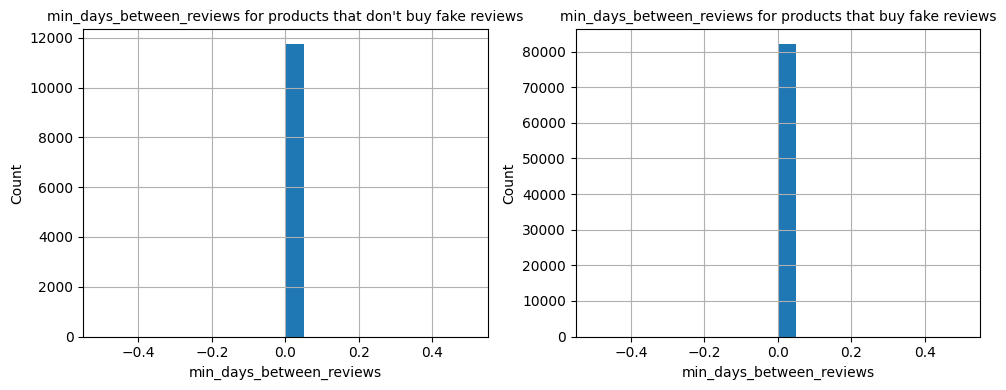

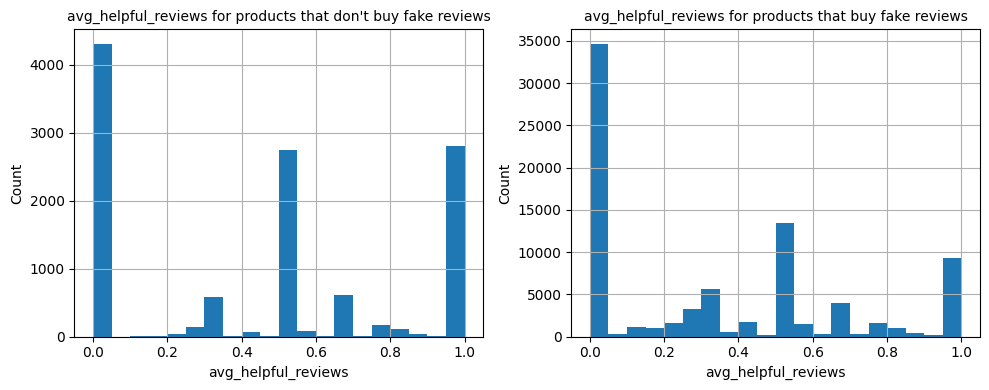

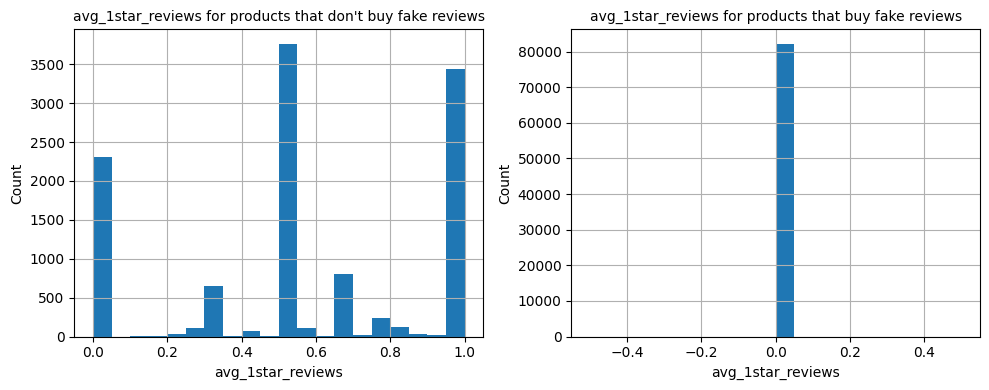

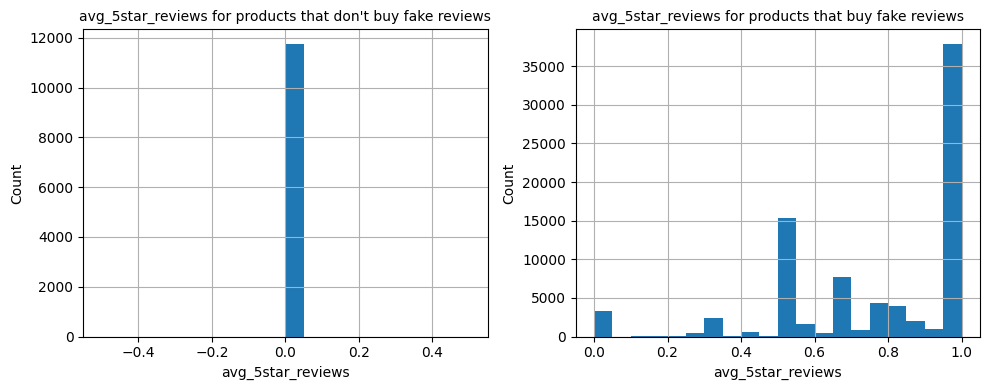

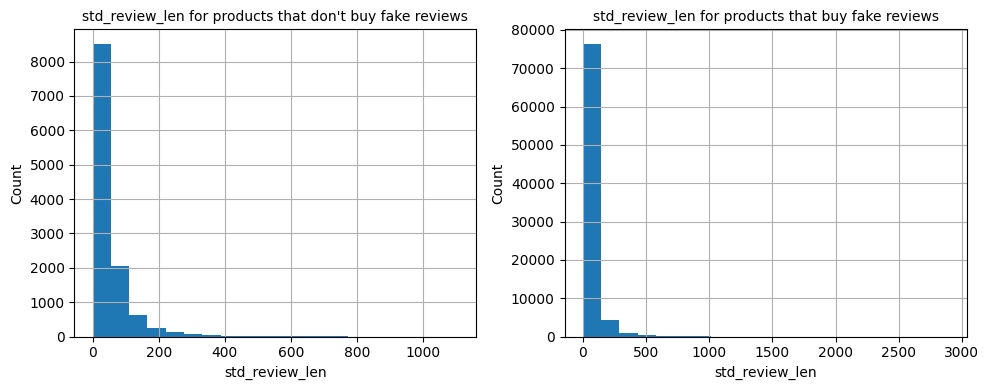

In [ ]:
#completing EDA plotting for all review metadata features
for i in reviews_metadata[review_features]:
  eda_plotting(reviews_metadata, i)

In [ ]:
#defining regex pattern to apply to remove stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

data = []
#go through the text of each review (title + review body)
for i in reviews_with_prod_label["text"]:
  #apply pattern to remove stopwords
  text = pattern.sub('', i)
  #add to list of strings with stopwords removed
  data.append(text)

#set text of reviews with stop words removed to text feature in dataframe
reviews_with_prod_label["text"] = data
#create snowball stemmer object
stemmer = SnowballStemmer(language='english')
#apply stemmer to the text of each review
reviews_with_prod_label["text"] = reviews_with_prod_label["text"].apply(
    lambda x: reduce(lambda y, z: y + " " + stemmer.stem(z), word_tokenize(x), "")
)

In [ ]:
#define X as products, as will use products to uniquely identify cases for each type of data (review metadata, network features, text features)
X = reviews_metadata[["product_ID"]]
#define y as fake label and corresponding product id so we can always use product id to rejoin to other dataframes
y = reviews_metadata[["fake", "product_ID"]]

#Overall: 80/10/10 train/validation/test split
#80/20 test/rest of data split, stratifying by label class (or if product does or does not buy fake reviews)
X_train, X_rest, y_train, y_rest  = train_test_split(X, y, train_size=0.8, random_state = 42, stratify = y["fake"])
#50/50 split of rest of data into validation/test, stratifying by label class (or if product does or does not buy fake reviews)
X_validation, X_test, y_validation, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = 42, stratify=y_rest['fake'])

#check to make sure all data split into correct proportions and the label was stratified
print("Train class distribution:\n", y_train["fake"].value_counts(), "\n")
print("Validation class distribution:\n", y_validation["fake"].value_counts(), "\n")
print("Test class distribution:\n", y_test["fake"].value_counts(), "\n")

Train class distribution:
 fake
1.0    65712
0.0     9402
Name: count, dtype: int64 

Validation class distribution:
 fake
1.0    8214
0.0    1175
Name: count, dtype: int64 

Test class distribution:
 fake
1.0    8215
0.0    1175
Name: count, dtype: int64 



In [ ]:
#define training review metadata as review metadata features that belong to products whose product ids are in the training set of product ids
X_train_reviews_metadata = reviews_metadata[reviews_metadata["product_ID"].isin(X_train["product_ID"])]
#repeat for validation set
X_validation_reviews_metadata = reviews_metadata[reviews_metadata["product_ID"].isin(X_validation["product_ID"])]
#repeat for testing set
X_test_reviews_metadata = reviews_metadata[reviews_metadata["product_ID"].isin(X_test["product_ID"])]

#drop product id and fake from training set of reviews metadata
X_train_reviews_metadata = X_train_reviews_metadata.drop(['product_ID', 'fake'], axis=1)
#repeat for validation set
X_validation_reviews_metadata = X_validation_reviews_metadata.drop(['product_ID', 'fake'], axis=1)
#repeat for test set
X_test_reviews_metadata = X_test_reviews_metadata.drop(['product_ID', 'fake'], axis=1)

In [ ]:
X_tr = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_train["product_ID"])]
#repeat for validation set
X_val = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_validation["product_ID"])]
#repeat for testing set
X_te = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_test["product_ID"])]

In [ ]:
print(X_tr.shape)
print(X_val.shape)
print(X_te.shape)

(279615, 10)
(35581, 10)
(34612, 10)


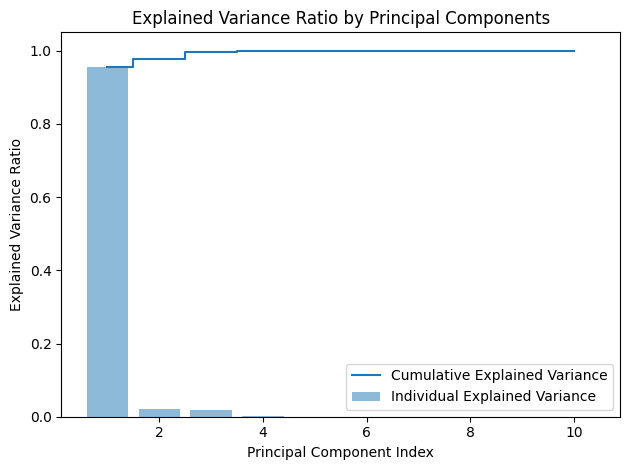

[0.9562711]


In [ ]:
#create pca object with no max number of components
pca = PCA(random_state = 42)
#fit to scaled training set reviews metadata
pca.fit(X_train_reviews_metadata)
#calculate explained variance for each component
explained_variance_ratio = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance_ratio)
#plot pca components and explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#as choosing to capture 95% of the variance with pca, need 1 pca component
pca = PCA(n_components=1, random_state = 42)
#fit and transform scaled training set of reviews metadata
X_train_review_features_pca = pca.fit_transform(X_train_reviews_metadata)
#transform scaled validation set of reviews metadata
X_validation_review_features_pca = pca.transform(X_validation_reviews_metadata)
#repeat for test data
X_test_review_features_pca = pca.transform(X_test_reviews_metadata)
#calculate explained variance for each component
explained_variance = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance)
#check that captured amount of variance want to capture with pca
print(cumulative_variance)

In [ ]:
#define training review text as text of reviews that belong to products whose product ids are in the training set of product ids
X_train_text = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_train["product_ID"])]
#repeat same process for validation text
X_validation_text = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_validation["product_ID"])]
#repeat same process for test text
X_test_text = reviews_with_prod_label[reviews_with_prod_label["product_ID"].isin(X_test["product_ID"])]

In [ ]:
#combine text of all reviews in the same product id into one line of text associated with product id
X_train_text_combined = (
    X_train_text.groupby('product_ID')['text']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

#repeat for validation text
X_validation_text_combined = (
    X_validation_text.groupby('product_ID')['text']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

#repeat for test text
X_test_text_combined = (
    X_test_text.groupby('product_ID')['text']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

In [ ]:
#apply tokenization of training text into list of words for each product (all reviews for product tokenized)
X_train_text_combined_tokenized = []
X_train_text_combined_tokenized = X_train_text_combined['text'].apply(lambda x: list(tokenize(x)))

#repeat for validation set
X_validation_text_combined_tokenized = []
X_validation_text_combined_tokenized = X_validation_text_combined['text'].apply(lambda x: list(tokenize(x)))

#repeat for test set
X_test_text_combined_tokenized = []
X_test_text_combined_tokenized = X_test_text_combined['text'].apply(lambda x: list(tokenize(x)))

In [ ]:
#define parameter grid of hyperparameters for a continuous bag of words Word2vec model
param_grid = {
    'vector_size': [150, 200],
    'window': [10, 15],
    'min_count': [500, 1000]
}

#randomly sample hyperparameter combinations for word2vec model
n_iter = 4
random_search = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

def train_and_evaluate(params):
  #fit word2vec model based on current parameters passed in
  model = gensim.models.Word2Vec(
      X_train_text_combined_tokenized,
      vector_size=params['vector_size'],
      window=params['window'],
      min_count=params['min_count'],
      workers = 1, #trying to be more deterministic, can remove
      seed = 42
  )
  #get average euclidean norm of all word vectors in trained model
  avg_vector_norm = np.mean([np.linalg.norm(model.wv[word]) for word in model.wv.index_to_key])
  return avg_vector_norm

best_score = -np.inf
best_params = None
#for set of parameters seraching through
for params in random_search:
  #get L2 norm of resulting model
  score = train_and_evaluate(params)
  #if getting higher norm than current best norm
  if score > best_score:
    #update best score and parameters of best model
    best_score = score
    best_params = params

In [ ]:
print("\nBest Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'window': 15, 'vector_size': 200, 'min_count': 1000}
Best Score: 19.687302


In [ ]:
#extract best vector size from random sampling of parameters
vector_size = best_params['vector_size']
#train word2vec using best parameters from random sampling of parameters
model1 = gensim.models.Word2Vec(X_train_text_combined_tokenized, **best_params, seed = 42)

In [ ]:
def get_avg_vector(tokens, model, vector_size):
  #funciton to get average vector for all text in reviews in a product
  #for each word, look up learned word2vec vector if exist in model vocabularity, if not skip word
  vectors = [model.wv[word] for word in tokens if word in model.wv]
  #get average emebedding across set of vectors, if no vectors return zero vector of size = vector_size
  return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

#apply function to entire set of products and their associated reviews in the training set
X_train_text_avg_vector = np.array([
    get_avg_vector(reviews_prod, model1, vector_size)
    for reviews_prod in X_train_text_combined_tokenized
])

#repeat for validation set
X_validation_text_avg_vector = np.array([
    get_avg_vector(reviews_prod, model1, vector_size)
    for reviews_prod in X_validation_text_combined_tokenized
])

#repeat for test set
X_test_text_avg_vector = np.array([
    get_avg_vector(reviews_prod, model1, vector_size)
    for reviews_prod in X_test_text_combined_tokenized
])

#output is 2d array where each row is a product's word emebedding (average across all word embeddings in set of reviews for product)
#column is an embedding dimension
#shape: (#of products, vector_size)
print(X_train_text_avg_vector.shape)
print(X_validation_text_avg_vector.shape)
print(X_test_text_avg_vector.shape)

(75114, 200)
(9389, 200)
(9390, 200)


In [ ]:
#create standard scaler object
scaler = StandardScaler()
#fit and transform training set vector representation from word2vec model
X_train_text_avg_vector_scaled = scaler.fit_transform(X_train_text_avg_vector)
#transform validation set vector representation from word2vec model
X_validation_text_avg_vector_scaled = scaler.transform(X_validation_text_avg_vector)
#repeat for text set vector representation
X_test_text_avg_vector_scaled = scaler.transform(X_test_text_avg_vector)

#convert scaled traning set vector representation from a array to a dataframe
X_train_text_avg_vector_scaled = pd.DataFrame(X_train_text_avg_vector_scaled)
#repeat for validation set
X_validation_text_avg_vector_scaled = pd.DataFrame(X_validation_text_avg_vector_scaled)
#repeat for text set
X_test_text_avg_vector_scaled = pd.DataFrame(X_test_text_avg_vector_scaled)

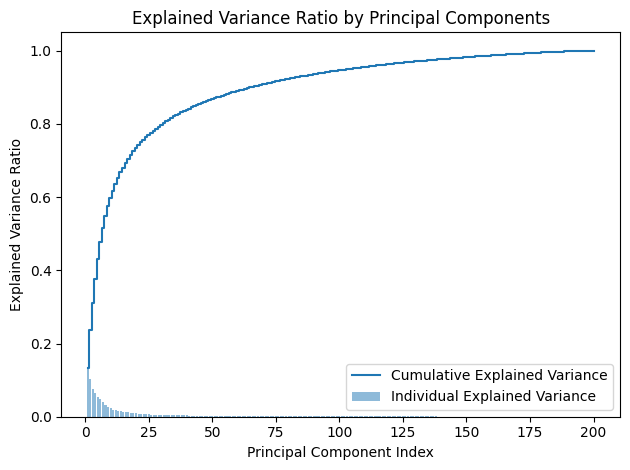

[0.13367026 0.23591357 0.31117082 0.376585   0.4295591  0.47680566
 0.5161786  0.5471161  0.57482386 0.5977448  0.61730134 0.63574404
 0.6525025  0.6672767  0.6805139  0.6927369  0.70457095 0.71572554
 0.7254111  0.7343968  0.74253887 0.7502982  0.7571005  0.7637922
 0.7699534  0.7759515  0.78167534 0.7872101  0.7924253  0.7976001
 0.80259734 0.80730134 0.8118612  0.8161272  0.82024896 0.8242324
 0.82803047 0.8316966  0.83515847 0.8385234  0.84177697 0.84500724
 0.8481741  0.8512158  0.854121   0.85692614 0.8597027  0.8623677
 0.86496675 0.8674749  0.86994445 0.87238073 0.87471205 0.8770115
 0.8792309  0.88138586 0.88352895 0.88565034 0.8877287  0.8897295
 0.89170146 0.89367014 0.895606   0.89749384 0.8993264  0.90113914]


In [ ]:
#create pca object with no max number of components
pca = PCA(random_state = 42)
#fit to scaled training set vector representation of text data
pca.fit(X_train_text_avg_vector_scaled)
#calculate explained variance for each component
explained_variance_ratio = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance_ratio)
#plot pca components and explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#choosing to capture 90% of the variance with pca
n_comp = np.argmax(cumulative_variance >= 0.90) + 1
pca = PCA(n_components=n_comp, random_state = 42)
#fit and transform scaled training set vector representation of text data
X_train_text_pca = pca.fit_transform(X_train_text_avg_vector_scaled)
#transform scaled validation set vector representation of text data
X_validation_text_pca = pca.transform(X_validation_text_avg_vector_scaled)
#repeat for test data
X_test_text_pca = pca.transform(X_test_text_avg_vector_scaled)
#calculate explained variance for each component
explained_variance = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance)
#check that captured amount of variance want to capture with pca
print(cumulative_variance)

In [ ]:
def weighted_projected_graph(B, nodes, ratio=False):
  if B.is_directed():
    pred = B.pred
    G = nx.DiGraph()
  else:
    pred = B.adj
    G = nx.Graph()
  G.graph.update(B.graph)
  G.add_nodes_from((n, B.nodes[n]) for n in nodes)
  n_top = float(len(B) - len(nodes))
  nodes_checked = []
  for u in nodes:
    nodes_checked.append(u)
    unbrs = set(B[u])
    nbrs2 = {n for nbr in unbrs for n in B[nbr]} - set(nodes_checked)
    for v in nbrs2:
      vnbrs = set(pred[v])
      common = unbrs & vnbrs
      if not ratio:
        weight = len(common)
      else:
        weight = len(common) / n_top
      G.add_edge(u, v, weight=weight)
  return G

def obtain_network_features(reviews):
  # initializing the product-level data
  df = pd.DataFrame({"product_ID": reviews.product_ID.unique()})

  # building the bipartite product-reviewer graph
  B = nx.Graph()
  B.add_nodes_from(reviews.reviewer_ID, bipartite=0)
  B.add_nodes_from(reviews.product_ID, bipartite=1)
  B.add_edges_from([(row['reviewer_ID'], row['product_ID']) for idx, row in reviews.iterrows()])

  # building the product projected graph
  P = weighted_projected_graph(B, reviews.product_ID.unique())

  nstart = {node: 1.0 for node in P.nodes()}

  # calculate features
  w_degree_cent = nx.degree(P, weight='weight')
  eig_cent = nx.eigenvector_centrality(P, max_iter=500, nstart=nstart)
  pr = nx.pagerank(P, alpha=0.85, nstart={node: 1.0 for node in P.nodes()})
  cc = nx.clustering(P)
  w_cc = nx.clustering(P, weight='weight')
  w_eig_cent = nx.eigenvector_centrality(P, max_iter=500, weight='weight', nstart=nstart)
  degree = nx.degree(P)
  w_pr = nx.pagerank(P, alpha=0.85, weight='weight', nstart={node: 1.0 for node in P.nodes()})

  # creating the features data
  df['pagerank'] = [pr[i] for i in df.product_ID]
  df['eigenvector_cent'] = [eig_cent[i] for i in df.product_ID]
  df['clustering_coef'] = [cc[i] for i in df.product_ID]
  df['w_degree'] = [w_degree_cent[i] for i in df.product_ID]
  df['degree'] = [degree[i] for i in df.product_ID]
  df['w_pagerank'] = [w_pr[i] for i in df.product_ID]
  df['w_clustering_coef'] = [w_cc[i] for i in df.product_ID]
  df['w_eigenvector_cent'] = [w_eig_cent[i] for i in df.product_ID]
  return df

In [ ]:
#define network features for training set of products and reviwers in training set of reviews
X_train_network = obtain_network_features(X_train_text)
#repeat for validation set
X_validation_network = obtain_network_features(X_validation_text)
#repeat for test set
X_test_network = obtain_network_features(X_test_text)

In [ ]:
#merge to get back fake label for eda plotting later
X_train_network = X_train_network.merge(X_train_text, on = "product_ID")
X_validation_network = X_validation_network.merge(X_validation_text, on = "product_ID")
X_test_network = X_test_network.merge(X_test_text, on = "product_ID")

#drop duplicates of network featuers so only have one instance network features for each product in the training set
X_train_with_network = X_train_network.drop_duplicates(subset=['product_ID'])
#repeat for validation set
X_validation_with_network = X_validation_network.drop_duplicates(subset=['product_ID'])
#repeat for test set
X_test_with_network = X_test_network.drop_duplicates(subset=['product_ID'])

#subset X_train_with_network to include only network features and fake label
X_train_with_network = X_train_with_network[['fake', 'pagerank', 'w_degree', 'clustering_coef', 'eigenvector_cent', 'degree', 'w_pagerank', 'w_clustering_coef', 'w_eigenvector_cent']]
#repeat for validation set
X_validation_with_network = X_validation_with_network[['fake', 'pagerank', 'w_degree', 'clustering_coef', 'eigenvector_cent', 'degree', 'w_pagerank', 'w_clustering_coef', 'w_eigenvector_cent']]
#repeat for test set
X_test_with_network = X_test_with_network[['fake', 'pagerank', 'w_degree', 'clustering_coef', 'eigenvector_cent', 'degree', 'w_pagerank', 'w_clustering_coef', 'w_eigenvector_cent']]

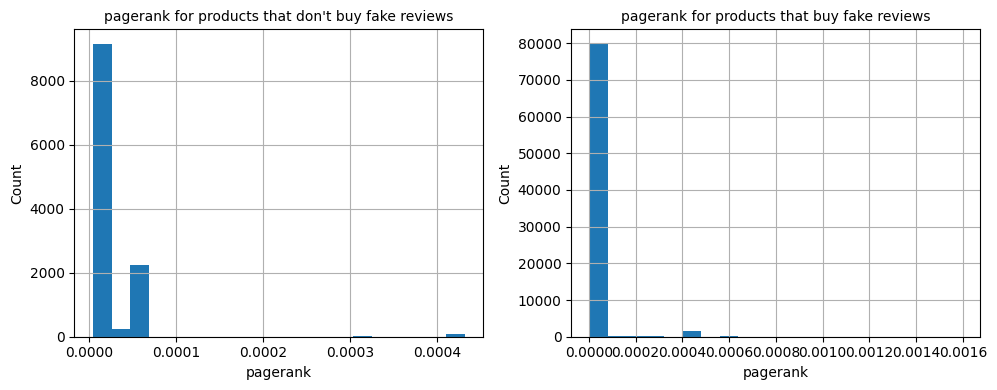

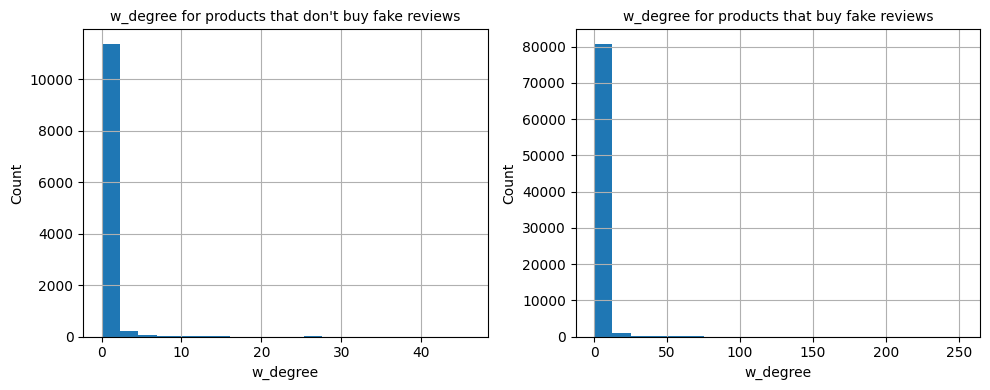

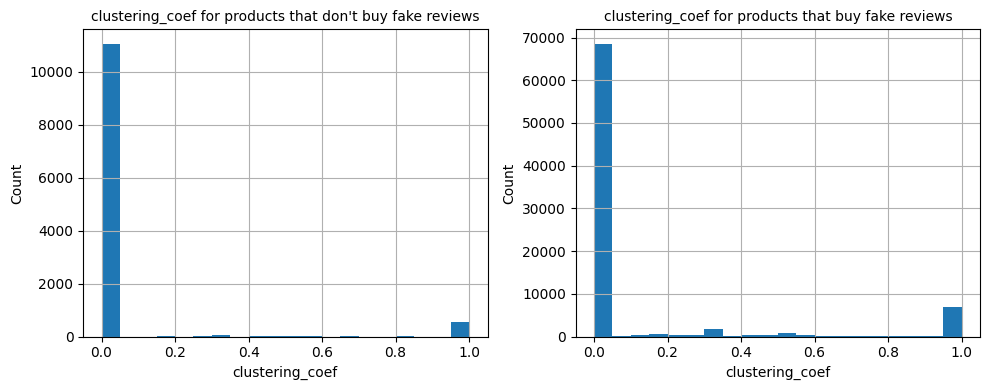

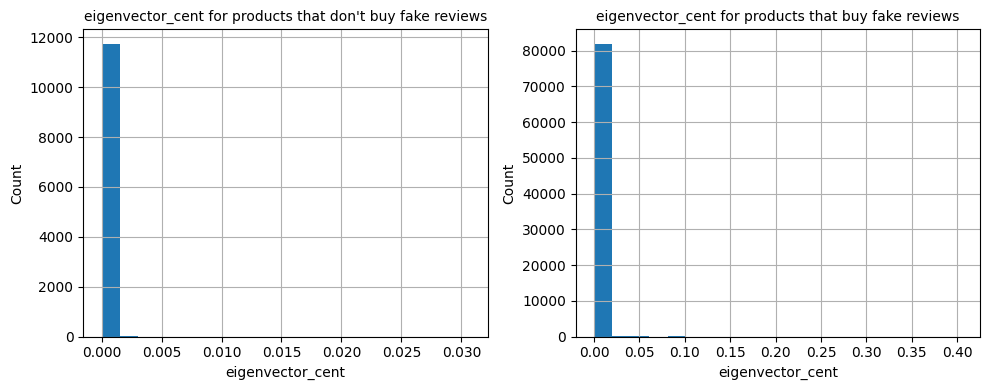

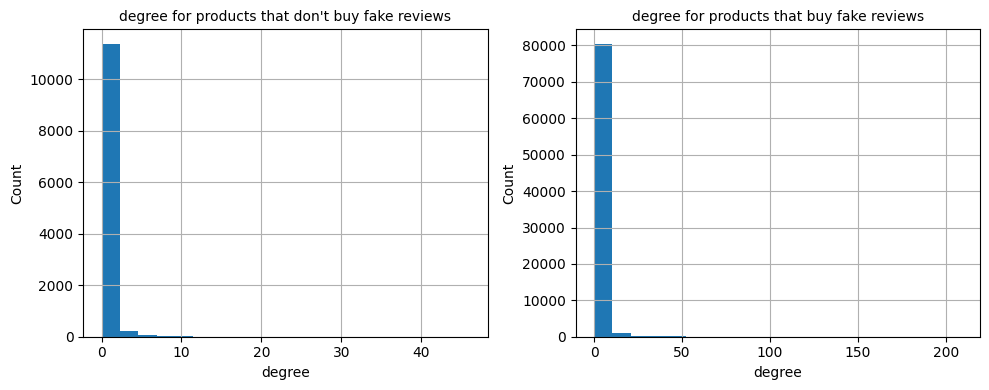

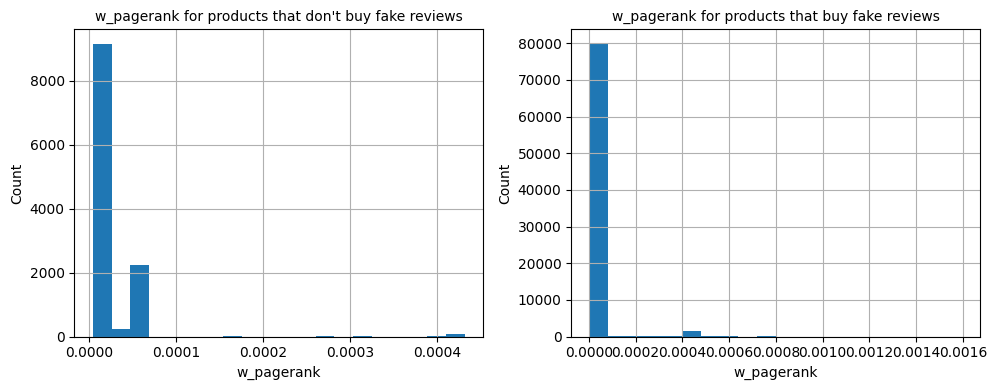

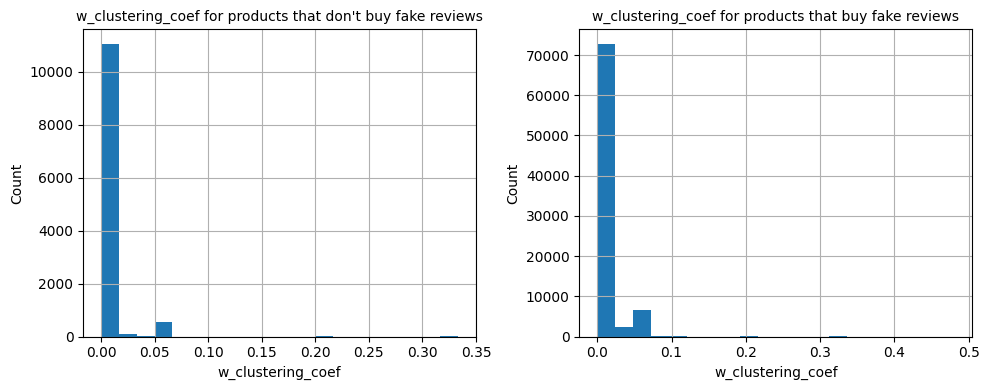

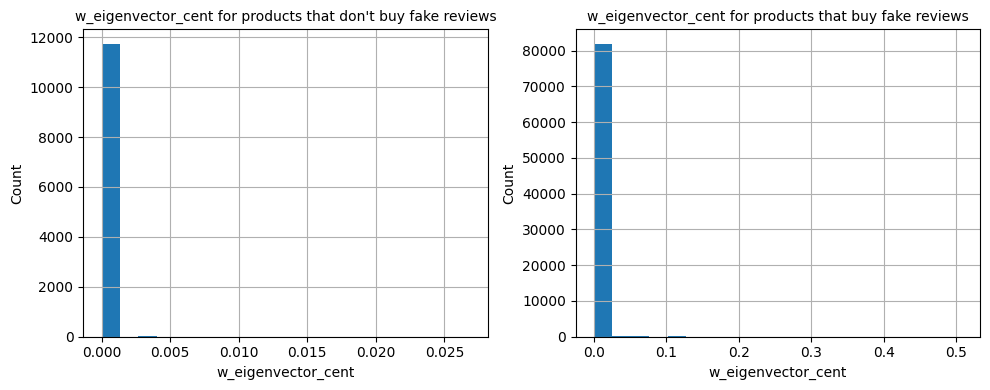

In [ ]:
#concatenate together network features for train/validation/test set for EDA plot
X_network_combined_for_eda = pd.concat([X_train_with_network, X_validation_with_network, X_test_with_network], axis=0)
#get eda plots for network features
for i in X_network_combined_for_eda[network_features]:
  eda_plotting(X_network_combined_for_eda, i)

In [ ]:
#drop fake feature from training set for rest of data as fake is label trying to predict
X_train_with_network = X_train_with_network.drop(['fake'], axis=1)
#repeat for validation set
X_validation_with_network = X_validation_with_network.drop(['fake'], axis=1)
#repeat for test set
X_test_with_network = X_test_with_network.drop(['fake'], axis=1)

In [ ]:
#create standard scaler object
scaler = StandardScaler()
#fit and transform training set network features
X_train_network_features_scaled = scaler.fit_transform(X_train_with_network)
#transform validation set network features
X_validation_network_features_scaled = scaler.transform(X_validation_with_network)
#repeat for text set network features
X_test_network_features_scaled = scaler.transform(X_test_with_network)

#convert scaled traning set network features from array to dataframe
X_train_network_features_scaled = pd.DataFrame(X_train_network_features_scaled, columns = network_features)
#repeat for validation set
X_validation_network_features_scaled = pd.DataFrame(X_validation_network_features_scaled, columns = network_features)
#repeat for test set
X_test_network_features_scaled = pd.DataFrame(X_test_network_features_scaled, columns = network_features)

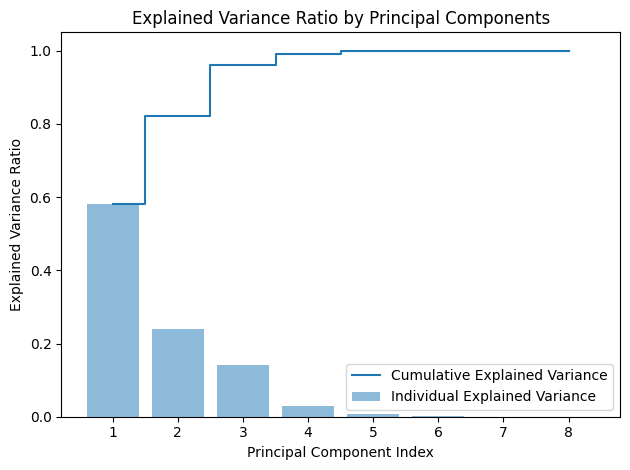

[0.58144686 0.82139465 0.96170047]


In [ ]:
#create pca object with no max number of components
pca = PCA(random_state = 42)
#fit to scaled training set of network features
pca.fit(X_train_network_features_scaled)
#calculate explained variance for each component
explained_variance_ratio = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance_ratio)
#plot pca components and explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


#as choosing to capture 95% of the variance with pca, need 3 pca components
pca = PCA(n_components=3, random_state = 42)
#fit and transform scaled training set network features
X_train_network_features_pca = pca.fit_transform(X_train_network_features_scaled)
#transform scaled validation set network features
X_validation_network_features_pca = pca.transform(X_validation_network_features_scaled)
#repeat for test data
X_test_network_features_pca = pca.transform(X_test_network_features_scaled)
#calculate explained variance for each component
explained_variance = pca.explained_variance_ratio_
#calculate explained variance as add each component
cumulative_variance = np.cumsum(explained_variance)
#check that captured amount of variance want to capture with pca
print(cumulative_variance)

In [ ]:
#get labels from y_train, as y_train has labels and product id
y_train_labels = y_train[["fake"]]
#repeat for y_validation
y_validation_labels = y_validation[["fake"]]
#repeat for y_test
y_test_labels = y_test[["fake"]]

#flatten dimensionality of y_train_labels so just array of values (prep for ml model inputs)
y_train_labels = y_train_labels.values.ravel()
#repeat for y_validation_labels
y_validation_labels = y_validation_labels.values.ravel()
#repeat for y_test_labels
y_test_labels = y_test_labels.values.ravel()

In [ ]:
def model_building(train, validation, model):
  #general function to evaluate model performance on model and data passed in
	#fit model
  model.fit(train, y_train_labels)
  #obtain label predictions on validation set
  y_pred = model.predict(validation)
  #get probability predictions using model on validation set
  probs = model.predict_proba(validation)[:,1]
  #get area under curve score and print out
  auc_score = roc_auc_score(y_validation_labels, probs)
  print("AUC score", auc_score)
  #get true postive rate, false postive rate for many thresholds based on predicted probabilties and validation labels
  fpr, tpr, thresholds = roc_curve(y_validation_labels, probs)
  #plot ROC curve with chance (50%) line and ROC curve of model
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

In [ ]:
def classification_results(X_train, X_validation):
  #general model to train set of candidate models
  #build logisitic regression model, fit on X_train, and evaluate on X_validation
  print("="*10 + "Logistic Regression" + "="*10)
  model = LogisticRegression(random_state = 42)
  model_building(X_train, X_validation, model)

  #build random forest classifier model, fit on X_train, and evaluate on X_validation
  print("="*10 + "Random Forest" + "="*10)
  model = RandomForestClassifier(random_state=42)
  model_building(X_train, X_validation, model)

  #build xgboost model, fit on X_train, and evaluate on X_validation
  print("="*10 + "XGBoost" + "="*10)
  model = xgb.XGBClassifier(random_state = 42)
  model_building(X_train, X_validation, model)

  return

==========Logistic Regression==========
AUC score 0.49586730491273334


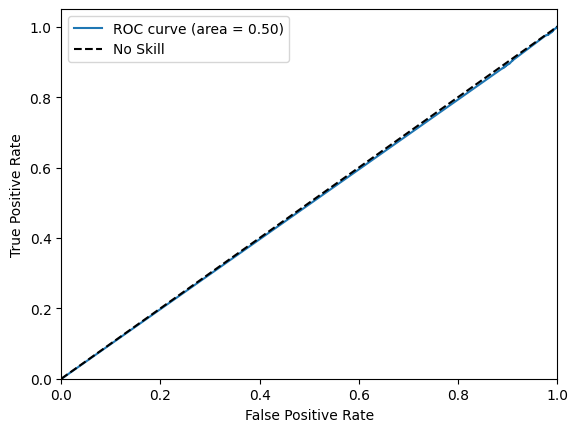

==========Random Forest==========
AUC score 0.4963587854674686


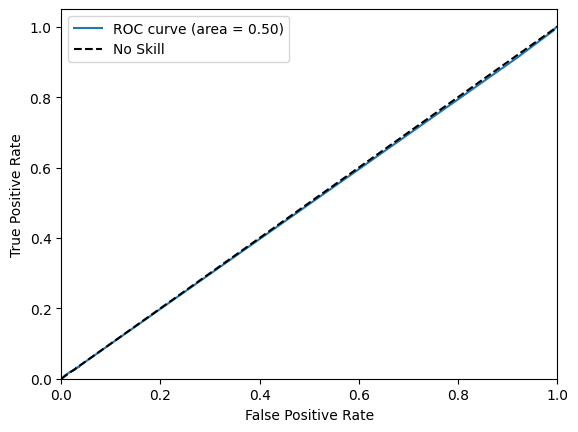

==========XGBoost==========
AUC score 0.4996515031420149


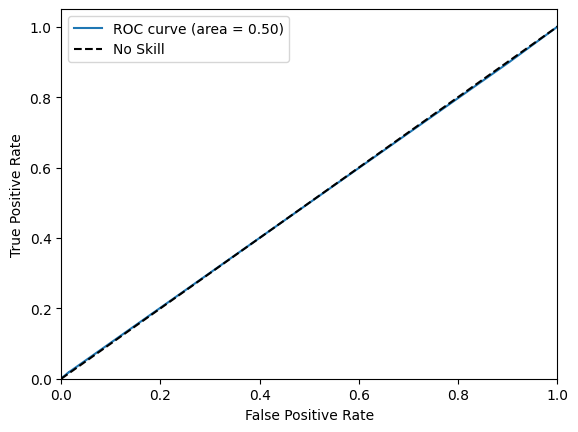

In [ ]:
#call set of models on network features
classification_results(X_train_network_features_pca, X_validation_network_features_pca)

In [ ]:
#as random forest was the best candidate model for network features
#hyperparameter tune random forest
#create set of hyperparameters for random forest
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

#build empty random forest classifier model
model = RandomForestClassifier(random_state = 42)

#define sample of random hyperparameter settings
random_search_network = RandomizedSearchCV(model,
                                   param_distributions, random_state = 42)
#fit set of hyperparameter settings sampled to network data, evaluate using training labels
random_search_network.fit(X_train_network_features_pca, y_train_labels)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42)

In [ ]:
#get best model from randomized hyperpameter serach
print(random_search_network.best_params_)

{'n_estimators': 200, 'max_features': None, 'max_depth': 5}


AUC score 0.4974970600272498


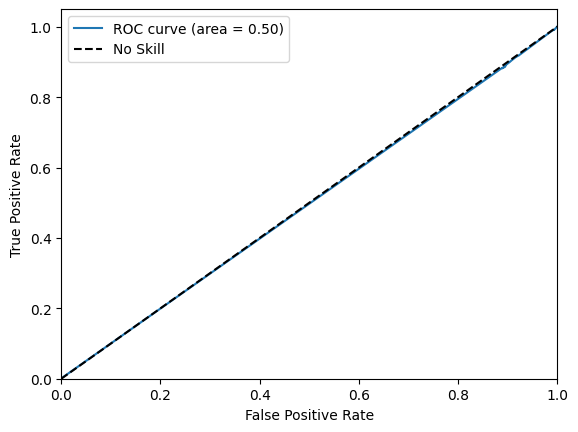

Youden’s J statistic 0.8673416696475214
Accuracy 0.12599850889338587
Precision 1.0
Recall 0.0009739469198928658
F1 Score 0.0019459985405010946


In [ ]:
#get predicted probabilties using best hyperparameter model on validation network data
predicted_probs_network = random_search_network.predict_proba(X_validation_network_features_pca)[:,1]
#get AUC score based on validation set and print out
auc_score_network = roc_auc_score(y_validation_labels, predicted_probs_network)
print("AUC score", auc_score_network)
#get true positive rate, false positive rate over many thresholds based on predcited probabilties and labels for validation set
fpr, tpr, thresholds = roc_curve(y_validation_labels, predicted_probs_network)
#plot ROC curve with chance (50%) line and ROC curve of model
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#get Youden's J Statistic, used to get best threshold to maximize area under the curve and print out
network_j_stat = thresholds[np.argmax(tpr-fpr)]
print("Youden’s J statistic", network_j_stat)

#use Youden's J Statistic as threshold to predict labels
predicted_labels_network = (predicted_probs_network >= network_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of validation set
accuracy_network = accuracy_score(y_validation_labels, predicted_labels_network)
print("Accuracy", accuracy_network)
precision_network = metrics.precision_score(y_validation_labels, predicted_labels_network)
print("Precision", precision_network)
recall_network = metrics.recall_score(y_validation_labels, predicted_labels_network)
print("Recall", recall_network)
f1_score_network = metrics.f1_score(y_validation_labels, predicted_labels_network)
print("F1 Score", f1_score_network)

==========Logistic Regression==========
AUC score 0.5067943158799972


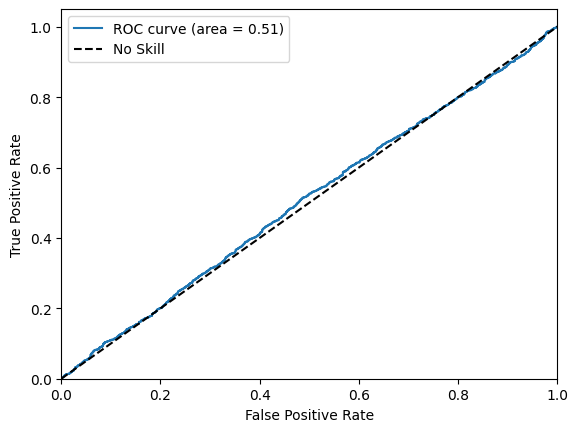

==========Random Forest==========
AUC score 0.5135364116272685


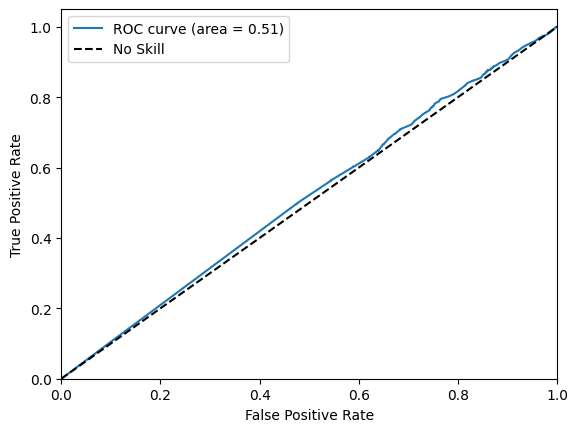

==========XGBoost==========
AUC score 0.5090480704971792


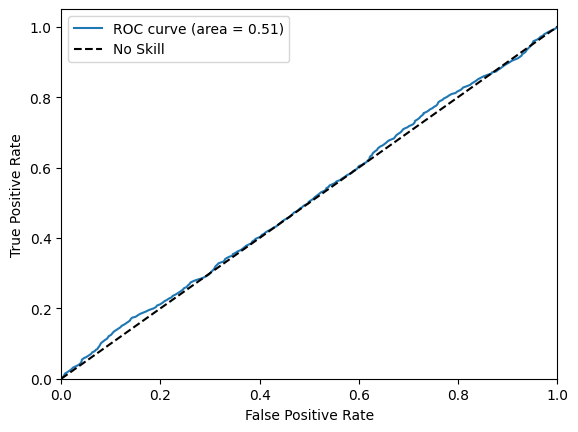

In [ ]:
#call set of models on review features
classification_results(X_train_review_features_pca, X_validation_review_features_pca)

In [ ]:
#as xgboost was the best candidate model for review features
#hyperparameter tune xgboost
#create set of hyperparameters for xgboost
param_distributions = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

#build xgboost classifier
model = XGBClassifier(random_state=42)

#define sample of random hyperparameter settings
random_search_review_info = RandomizedSearchCV(model,
                                   param_distributions, random_state = 42)
#fit set of hyperparameter settings sampled to review data, evaluate using training labels
random_search_review_info.fit(X_train_review_features_pca, y_train_labels)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=No...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=42)

In [ ]:
#get best model from randomized hyperpameter serach
print(random_search_review_info.best_params_)

{'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2}


AUC score 0.4974970600272498


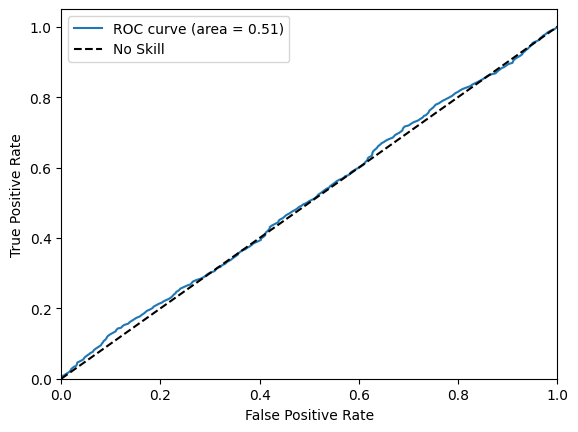

Youden’s J statistic 0.8909609
Accuracy 0.23580786026200873
Precision 0.8974751338944147
Recall 0.14280496712929144
F1 Score 0.246402688793194


In [ ]:
#get predicted probabilties using best hyperparameter model on validation review data
predicted_probs_review = random_search_review_info.predict_proba(X_validation_review_features_pca)[:,1]
#get AUC score based on validation set and print out
auc_score_review = roc_auc_score(y_validation_labels, predicted_probs_review)
print("AUC score", auc_score_network)
#get true positive rate, false positive rate over many thresholds based on predcited probabilties and labels for validation set
fpr, tpr, thresholds = roc_curve(y_validation_labels, predicted_probs_review)
#plot ROC curve with chance (50%) line and ROC curve of model
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#get Youden's J Statistic, used to get best threshold to maximize area under the curve and print out
review_j_stat = thresholds[np.argmax(tpr-fpr)]
print("Youden’s J statistic", review_j_stat)

#use Youden's J Statistic as threshold to predict labels
predicted_labels_review_info = (predicted_probs_review >= review_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of validation set
accuracy_review_info = accuracy_score(y_validation_labels, predicted_labels_review_info)
print("Accuracy", accuracy_review_info)
precision_review_info = metrics.precision_score(y_validation_labels, predicted_labels_review_info)
print("Precision", precision_review_info)
recall_review_info = metrics.recall_score(y_validation_labels, predicted_labels_review_info)
print("Recall", recall_review_info)
f1_score_review_info = metrics.f1_score(y_validation_labels, predicted_labels_review_info)
print("F1 Score", f1_score_review_info)

==========Logistic Regression==========
AUC score 0.5070775893777619


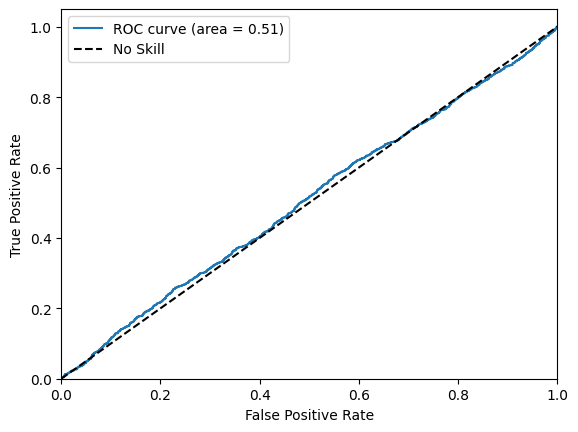

==========Random Forest==========
AUC score 0.5046870677462972


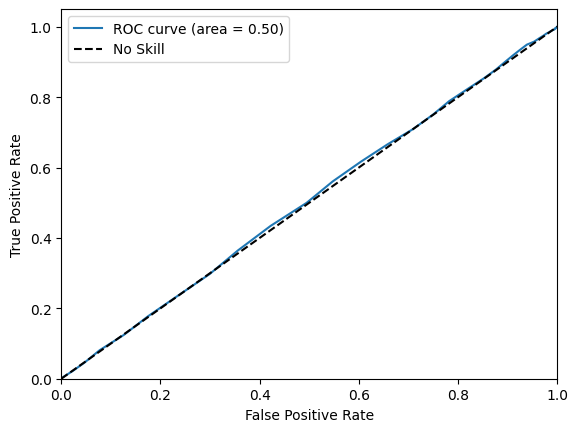

==========XGBoost==========
AUC score 0.5089619694450057


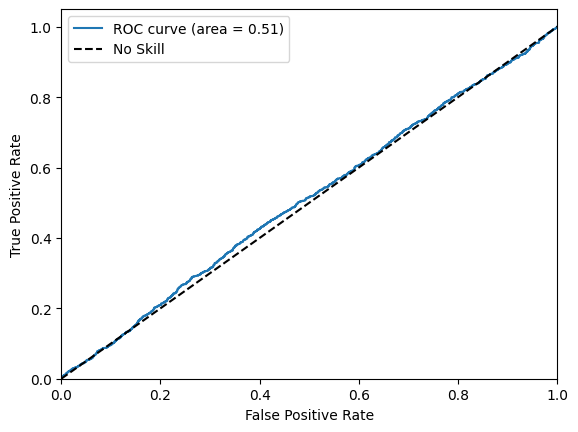

In [ ]:
#call set of models on text features
classification_results(X_train_text_pca, X_validation_text_pca)

In [ ]:
#as xgboost classifier was the best candidate model for text features
#hyperparameter tune xgboost
#create set of hyperparameters for xgboost

param_distributions = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

#build xgboost classifier
model = XGBClassifier(random_state=42)
#define sample of random hyperparameter settings
random_search_text = RandomizedSearchCV(model,
                                   param_distributions, random_state = 42)
#fit set of hyperparameter settings sampled to text data, evaluate using training labels
random_search_text.fit(X_train_text_pca, y_train_labels)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=No...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=42)

In [ ]:
#get best model from randomized hyperpameter serach
print(random_search_text.best_params_)

{'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2}


AUC score 0.5126560775841972


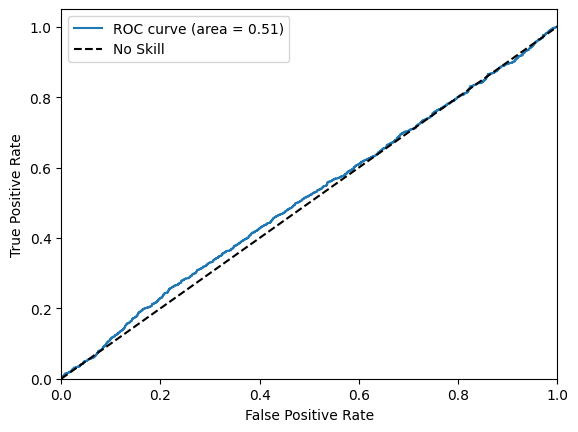

Youden’s J statistic 0.8878236
Accuracy 0.321546490574076
Precision 0.8913412563667232
Recall 0.2556610664718773
F1 Score 0.3973509933774834


In [ ]:
#get predicted probabilties using best hyperparameter model on validation text data
predicted_probs_text = random_search_text.predict_proba(X_validation_text_pca)[:,1]
#get AUC score based on validation set and print out
auc_score_text = roc_auc_score(y_validation_labels, predicted_probs_text)
print("AUC score", auc_score_text)
#get true positive rate, false positive rate over many thresholds based on predcited probabilties and labels for validation set
fpr, tpr, thresholds = roc_curve(y_validation_labels, predicted_probs_text)
#plot ROC curve with chance (50%) line and ROC curve of model
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#get Youden's J Statistic, used to get best threshold to maximize area under the curve and print out
text_j_stat = thresholds[np.argmax(tpr-fpr)]
print("Youden’s J statistic", text_j_stat)
#use Youden's J Statistic as threshold to predict labels
predicted_labels_text = (predicted_probs_text >= text_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of validation set
accuracy_text = accuracy_score(y_validation_labels, predicted_labels_text)
print("Accuracy", accuracy_text)
precision_text = metrics.precision_score(y_validation_labels, predicted_labels_text)
print("Precision", precision_text)
recall_text = metrics.recall_score(y_validation_labels, predicted_labels_text)
print("Recall", recall_text)
f1_score_text = metrics.f1_score(y_validation_labels, predicted_labels_text)
print("F1 Score", f1_score_text)

AUC score 0.5147716664335411


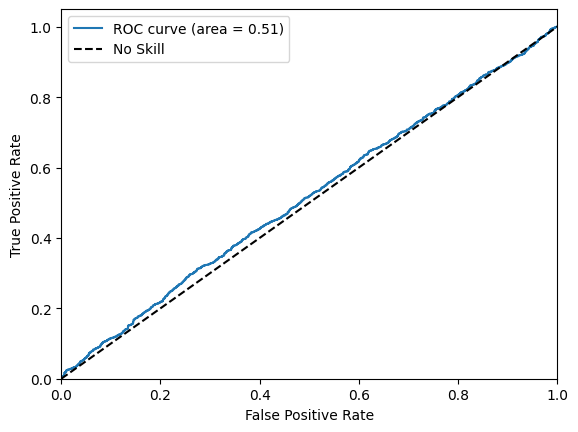

Youden’s J statistic 0.8820162242725794


In [ ]:
#get array of f1 scores for model trained on network features, review features, and text features
f1_scores = np.array([f1_score_network, f1_score_review_info, f1_score_text])
#normalize f1 scores so all sum of f1 scores adds up to one
weights = f1_scores / f1_scores.sum()
#calculate weighted probability of the product buying fake reviews based on the normalized f1 score of each model
f1_weighted_probs = weights[0]*predicted_probs_network + weights[1]*predicted_probs_review + weights[2]*predicted_probs_text
#get AUC score based on validation set and print out
auc_score_f1_weighted = roc_auc_score(y_validation_labels, f1_weighted_probs)
print("AUC score", auc_score_f1_weighted)
#get true positive rate, false positive rate over many thresholds based on predcited probabilties and labels for validation set
fpr, tpr, thresholds = roc_curve(y_validation_labels, f1_weighted_probs)
#plot ROC curve with chance (50%) line and ROC curve of model
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#get Youden's J Statistic, used to get best threshold to maximize area under the curve and print out
f1_weighted_j_stat = thresholds[np.argmax(tpr-fpr)]
print("Youden’s J statistic", f1_weighted_j_stat)
#use Youden's J Statistic as threshold to predict labels
predicted_labels_f1_weighted = (f1_weighted_probs >= f1_weighted_j_stat).astype(int)

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_f1based = accuracy_score(y_validation_labels, predicted_labels_f1_weighted)
print("Accuracy (weighted sum on F1):", accuracy_f1based)
print("Accuracy of network model:", accuracy_network)
print("Accuracy of review info model:", accuracy_review_info)
print("Accuracy of text model:", accuracy_text)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_f1based = metrics.precision_score(y_validation_labels, predicted_labels_f1_weighted)
print("Precision (weighted sum on F1):", precision_f1based)
print("Precision of network model:", precision_network)
print("Precision of review info model:", precision_review_info)
print("Precision of text model:", precision_text)
print("\n")

#get recall for combined model, compare to reacall of each model trained on subset of features
recall_f1based = metrics.recall_score(y_validation_labels, predicted_labels_f1_weighted)
print("Recall (weighted sum on F1):", recall_f1based)
print("Recall of network model:", recall_network)
print("Recall of review info model:", recall_review_info)
print("Recall of text model:", recall_text)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_f1based = metrics.f1_score(y_validation_labels, predicted_labels_f1_weighted)
print("F1 Score (weighted sum on F1):", f1_score_f1based)
print("F1 Score of network model:", f1_score_network)
print("F1 Score of review info model:", f1_score_review_info)
print("F1 Score of text model:", f1_score_text)

Accuracy (weighted sum on F1): 0.36457556715305145
Accuracy of network model: 0.12599850889338587
Accuracy of review info model: 0.23580786026200873
Accuracy of text model: 0.321546490574076


Precision (weighted sum on F1): 0.8883897719419489
Precision of network model: 1.0
Precision of review info model: 0.8974751338944147
Precision of text model: 0.8913412563667232


Recall (weighted sum on F1): 0.3130021913805698
Recall of network model: 0.0009739469198928658
Recall of review info model: 0.14280496712929144
Recall of text model: 0.2556610664718773


F1 Score (weighted sum on F1): 0.4629096146921138
F1 Score of network model: 0.0019459985405010946
F1 Score of review info model: 0.246402688793194
F1 Score of text model: 0.3973509933774834


AUC score 0.5101130918152195


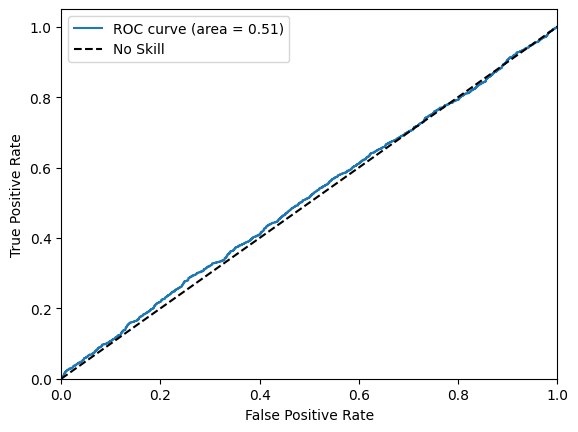

Youden’s J statistic 0.8782932391124165


In [ ]:
#get array of accuracy scores for model trained on network features, review features, and text features
accuracy_scores = np.array([accuracy_network, accuracy_review_info, accuracy_text])
#normalize accuracy scores so all sum of all accuracy scores adds up to one
weights = accuracy_scores / accuracy_scores.sum()
#calculate weighted probability of the product buying fake reviews based on the normalized accuracy score of each model
accuracy_weighted_probs= weights[0]*predicted_probs_network + weights[1]*predicted_probs_review + weights[2]*predicted_probs_text
#get AUC score based on validation set and print out
auc_score_accuracy_weighted = roc_auc_score(y_validation_labels, accuracy_weighted_probs)
print("AUC score", auc_score_accuracy_weighted)
#get true positive rate, false positive rate over many thresholds based on predicted probabilties and labels for validation set
fpr, tpr, thresholds = roc_curve(y_validation_labels, accuracy_weighted_probs)
#plot ROC curve with chance (50%) line and ROC curve of model
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#get Youden's J Statistic, used to get best threshold to maximize area under the curve and print out
accuracy_weighted_j_stat = thresholds[np.argmax(tpr-fpr)]
print("Youden’s J statistic", accuracy_weighted_j_stat)
#use Youden's J Statistic as threshold to predict labels
predicted_labels_accuracy_weighted = (accuracy_weighted_probs >= accuracy_weighted_j_stat).astype(int)

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_accuracybased = accuracy_score(y_validation_labels, predicted_labels_accuracy_weighted)
print("Accuracy (weighted sum on accuracy):", accuracy_accuracybased)
print("Accuracy of network model:", accuracy_network)
print("Accuracy of review info model:", accuracy_review_info)
print("Accuracy of text model:", accuracy_text)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_accuracybased = metrics.precision_score(y_validation_labels, predicted_labels_accuracy_weighted)
print("Precision (weighted sum on accuracy):", precision_accuracybased)
print("Precision of network model:", precision_network)
print("Precision of review info model:", precision_review_info)
print("Precision of text model:", precision_text)
print("\n")


#get recall for combined model, compare to reacall of each model trained on subset of features
recall_accuracybased = metrics.recall_score(y_validation_labels, predicted_labels_accuracy_weighted)
print("Recall (weighted sum on accuracy):", recall_accuracybased)
print("Recall of network model:", recall_network)
print("Recall of review info model:", recall_review_info)
print("Recall of text model:", recall_text)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_accuracybased = metrics.f1_score(y_validation_labels, predicted_labels_accuracy_weighted)
print("F1 Score (weighted sum on accuracy):", f1_score_accuracybased)
print("F1 Score of network model:", f1_score_network)
print("F1 Score of review info model:", f1_score_review_info)
print("F1 Score of text model:", f1_score_text)

Accuracy (weighted sum on accuracy): 0.3433805517094472
Accuracy of network model: 0.12599850889338587
Accuracy of review info model: 0.23580786026200873
Accuracy of text model: 0.321546490574076


Precision (weighted sum on accuracy): 0.8864579403998492
Precision of network model: 1.0
Precision of review info model: 0.8974751338944147
Precision of text model: 0.8913412563667232


Recall (weighted sum on accuracy): 0.28609690771852936
Recall of network model: 0.0009739469198928658
Recall of review info model: 0.14280496712929144
Recall of text model: 0.2556610664718773


F1 Score (weighted sum on accuracy): 0.4325816843074091
F1 Score of network model: 0.0019459985405010946
F1 Score of review info model: 0.246402688793194
F1 Score of text model: 0.3973509933774834


In [ ]:
#make dataframe where each column is the predicted labels on the validation set for each model based on subset of features (network, review, and text)
final_labels_df = pd.DataFrame({
    'predicted_labels_network': predicted_labels_network,
    'predicted_labels_review_info': predicted_labels_review_info,
    'predicted_labels_text': predicted_labels_text
})
#take majority vote of labels for each observation in validation data set
final_labels_df["final_labels"] = final_labels_df.mode(axis=1)[0]
#get majority vote predicted labels as an array in order to easily compare to the true validation set labels
final_labels_majority = np.array(final_labels_df["final_labels"])

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_majority = accuracy_score(y_validation_labels, final_labels_majority)
print("Accuracy (majority vote):", accuracy_majority)
print("Accuracy of network model: ", accuracy_network)
print("Accuracy of review info model: ", accuracy_review_info)
print("Accuracy of text model: ", accuracy_text)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_majority = metrics.precision_score(y_validation_labels, final_labels_majority)
print("Precision (majority vote):", precision_majority)
print("Precision of network model: ", precision_network)
print("Precision of review info model: ", precision_review_info)
print("Precision of text model: ", precision_text)
print("\n")

#get recall for combined model, compare to reacall of each model trained on subset of features
recall_majority = metrics.recall_score(y_validation_labels, final_labels_majority)
print("Recall (majority vote):", recall_majority)
print("Recall of network model: ", recall_network)
print("Recall of review info model: ", recall_review_info)
print("Recall of text model: ", recall_text)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_majority = metrics.f1_score(y_validation_labels, final_labels_majority)
print("F1 Score (majority vote):", f1_score_majority)
print("F1 Score of network model: ", f1_score_network)
print("F1 Score of review info model: ", f1_score_review_info)
print("F1 Score of text model: ", f1_score_text)

Accuracy (majority vote): 0.1534774736393652
Accuracy of network model:  0.12599850889338587
Accuracy of review info model:  0.23580786026200873
Accuracy of text model:  0.321546490574076


Precision (majority vote): 0.9130434782608695
Precision of network model:  1.0
Precision of review info model:  0.8974751338944147
Precision of text model:  0.8913412563667232


Recall (majority vote): 0.03579254930606282
Recall of network model:  0.0009739469198928658
Recall of review info model:  0.14280496712929144
Recall of text model:  0.2556610664718773


F1 Score (majority vote): 0.06888472352389878
F1 Score of network model:  0.0019459985405010946
F1 Score of review info model:  0.246402688793194
F1 Score of text model:  0.3973509933774834


## Testing Set Metrics

## Network Model

In [ ]:
#get predicted probabilties that product do or do not buy fake reviews for the test set
predicted_probs_network_test = random_search_network.predict_proba(X_test_network_features_pca)[:,1]
#using threshold for validation set, predict test set labels
predicted_labels_network_test = (predicted_probs_network_test >= network_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of test set
accuracy_network_test = accuracy_score(y_test_labels, predicted_labels_network_test)
print("Accuracy", accuracy_network_test)
precision_network_test = metrics.precision_score(y_test_labels, predicted_labels_network_test)
print("Precision", precision_network_test)
recall_network_test = metrics.recall_score(y_test_labels, predicted_labels_network_test)
print("Recall", recall_network_test)
f1_score_network_test = metrics.f1_score(y_test_labels, predicted_labels_network_test)
print("F1 Score", f1_score_network_test)

Accuracy 0.12673056443024494
Precision 0.8947368421052632
Recall 0.0020693852708460136
F1 Score 0.004129220306048093


##Review Fetures Model

In [ ]:
#get predicted probabilties that product do or do not buy fake reviews for the test set
predicted_probs_review_test = random_search_review_info.predict_proba(X_test_review_features_pca)[:,1]
#using threshold for validation set, predict test set labels
predicted_labels_review_test = (predicted_probs_review_test >= review_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of test set
accuracy_review_test = accuracy_score(y_test_labels, predicted_labels_review_test)
print("Accuracy", accuracy_review_test)
precision_review_test = metrics.precision_score(y_test_labels, predicted_labels_review_test)
print("Precision", precision_review_test)
recall_review_test = metrics.recall_score(y_test_labels, predicted_labels_review_test)
print("Recall", recall_review_test)
f1_score_review_test = metrics.f1_score(y_test_labels, predicted_labels_review_test)
print("F1 Score", f1_score_review_test)

Accuracy 0.22715654952076678
Precision 0.8650914634146342
Recall 0.13816189896530737
F1 Score 0.2382701794898709


#Text Model

In [ ]:
#get predicted probabilties that product do or do not buy fake reviews for the test set
predicted_probs_text_test = random_search_text.predict_proba(X_test_text_pca)[:,1]
#using threshold for validation set, predict test set labels
predicted_labels_text_test = (predicted_probs_text_test >= text_j_stat).astype(int)
#obtain metrics using predicted labels and actual labels of test set
accuracy_text_test = accuracy_score(y_test_labels, predicted_labels_text_test)
print("Accuracy", accuracy_text_test)
precision_text_test = metrics.precision_score(y_test_labels, predicted_labels_text_test)
print("Precision", precision_text_test)
recall_text_test = metrics.recall_score(y_test_labels, predicted_labels_text_test)
print("Recall", recall_text_test)
f1_score_text_test = metrics.f1_score(y_test_labels, predicted_labels_text_test)
print("F1 Score", f1_score_text_test)

Accuracy 0.31458998935037275
Precision 0.8692403486924035
Recall 0.2548995739500913
F1 Score 0.3942018072289157


#F1 Based Weighted Sum

In [ ]:
#get array of f1 scores for model trained on network features, review features, and text features
f1_scores = np.array([f1_score_network_test, f1_score_review_test, f1_score_text_test])
#normalize f1 scores so all sum of f1 scores adds up to one
weights = f1_scores / f1_scores.sum()
#calculate weighted probability of the product buying fake reviews based on the normalized f1 score of each model
f1_weighted_probs_test = weights[0]*predicted_probs_network_test + weights[1]*predicted_probs_review_test + weights[2]*predicted_probs_text_test
predicted_labels_f1_weighted_test = (f1_weighted_probs_test >= f1_weighted_j_stat).astype(int)

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_f1based_test = accuracy_score(y_test_labels, predicted_labels_f1_weighted_test)
print("Accuracy (weighted sum on F1):", accuracy_f1based_test)
print("Accuracy of network model:", accuracy_network_test)
print("Accuracy of review info model:", accuracy_review_test)
print("Accuracy of text model:", accuracy_text_test)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_f1based_test = metrics.precision_score(y_test_labels, predicted_labels_f1_weighted_test)
print("Precision (weighted sum on F1):", precision_f1based_test)
print("Precision of network model:", precision_network_test)
print("Precision of review info model:", precision_review_test)
print("Precision of text model:", precision_text_test)
print("\n")

#get recall for combined model, compare to reacall of each model trained on subset of features
recall_f1based_test = metrics.recall_score(y_test_labels, predicted_labels_f1_weighted_test)
print("Recall (weighted sum on F1):", recall_f1based_test)
print("Recall of network model:", recall_network_test)
print("Recall of review info model:", recall_review_test)
print("Recall of text model:", recall_text_test)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_f1based_test = metrics.f1_score(y_test_labels, predicted_labels_f1_weighted_test)
print("F1 Score (weighted sum on F1):", f1_score_f1based_test)
print("F1 Score of network model:", f1_score_network_test)
print("F1 Score of review info model:", f1_score_review_test)
print("F1 Score of text model:", f1_score_text_test)
print("\n")

Accuracy (weighted sum on F1): 0.3516506922257721
Accuracy of network model: 0.12673056443024494
Accuracy of review info model: 0.22715654952076678
Accuracy of text model: 0.31458998935037275


Precision (weighted sum on F1): 0.8691426587990281
Precision of network model: 0.8947368421052632
Precision of review info model: 0.8650914634146342
Precision of text model: 0.8692403486924035


Recall (weighted sum on F1): 0.30480827754108336
Recall of network model: 0.0020693852708460136
Recall of review info model: 0.13816189896530737
Recall of text model: 0.2548995739500913


F1 Score (weighted sum on F1): 0.4513338139870223
F1 Score of network model: 0.004129220306048093
F1 Score of review info model: 0.2382701794898709
F1 Score of text model: 0.3942018072289157




## Accuracy Weighted Sum

In [ ]:
#get array of accuracy scores for model trained on network features, review features, and text features
accuracy_scores = np.array([accuracy_network_test, accuracy_review_test, accuracy_text_test])
#normalize accuracy scores so all sum of all accuracy scores adds up to one
weights = accuracy_scores / accuracy_scores.sum()
#calculate weighted probability of the product buying fake reviews based on the normalized accuracy score of each model
accuracy_weighted_probs_test= weights[0]*predicted_probs_network_test + weights[1]*predicted_probs_review_test + weights[2]*predicted_probs_text_test
predicted_labels_accuracy_weighted_test = (accuracy_weighted_probs_test >= accuracy_weighted_j_stat).astype(int)

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_accuracybased_test = accuracy_score(y_test_labels, predicted_labels_accuracy_weighted_test)
print("Accuracy (weighted sum on accuracy):", accuracy_accuracybased_test)
print("Accuracy of network model:", accuracy_network_test)
print("Accuracy of review info model:", accuracy_review_test)
print("Accuracy of text model:", accuracy_text_test)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_accuracybased_test = metrics.precision_score(y_test_labels, predicted_labels_accuracy_weighted_test)
print("Precision (weighted sum on accuracy):", precision_accuracybased_test)
print("Precision of network model", precision_network_test)
print("Precision of review info model:", precision_review_test)
print("Precision of text model:", precision_text_test)
print("\n")

#get recall for combined model, compare to reacall of each model trained on subset of features
recall_accuracybased_test = metrics.recall_score(y_test_labels, predicted_labels_accuracy_weighted_test)
print("Recall (weighted sum on accuracy):", recall_accuracybased_test)
print("Recall of network model:", recall_network_test)
print("Recall of review info model:", recall_review_test)
print("Recall of text model:", recall_text_test)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_accuracybased_test = metrics.f1_score(y_test_labels, predicted_labels_accuracy_weighted_test)
print("F1 Score (weighted sum on accuracy):", f1_score_accuracybased_test)
print("F1 Score of network model:", f1_score_network_test)
print("F1 Score of review info model:", f1_score_review_test)
print("F1 Score of text model:", f1_score_text_test)

Accuracy (weighted sum on accuracy): 0.33258785942492014
Accuracy of network model: 0.12673056443024494
Accuracy of review info model: 0.22715654952076678
Accuracy of text model: 0.31458998935037275


Precision (weighted sum on accuracy): 0.8669932177844762
Precision of network model 0.8947368421052632
Precision of review info model: 0.8650914634146342
Precision of text model: 0.8692403486924035


Recall (weighted sum on accuracy): 0.2800973828362751
Recall of network model: 0.0020693852708460136
Recall of review info model: 0.13816189896530737
Recall of text model: 0.2548995739500913


F1 Score (weighted sum on accuracy): 0.4234060171128899
F1 Score of network model: 0.004129220306048093
F1 Score of review info model: 0.2382701794898709
F1 Score of text model: 0.3942018072289157


## Majority Vote

In [ ]:
#make dataframe where each column is the predicted labels on the test set for each model based on subset of features (network, review, and text)
final_labels_df = pd.DataFrame({
    'predicted_labels_network': predicted_labels_network_test,
    'predicted_labels_review_info': predicted_labels_review_test,
    'predicted_labels_text': predicted_labels_text_test
})
#take majority vote of labels for each observation in validation data set
final_labels_df["final_labels"] = final_labels_df.mode(axis=1)[0]
#get majority vote predicted labels as an array in order to easily compare to the true validation set labels
final_labels_majority_test = np.array(final_labels_df["final_labels"])

In [ ]:
#get accuracy for combined model, compare to accuracy of each model trained on subset of features
accuracy_majority_test = accuracy_score(y_test_labels, final_labels_majority_test)
print("Accuracy (majority vote):", accuracy_majority_test)
print("Accuracy of network model: ", accuracy_network_test)
print("Accuracy of review info model: ", accuracy_review_test)
print("Accuracy of text model: ", accuracy_text_test)
print("\n")

#get precision for combined model, compare to precision of each model trained on subset of features
precision_majority_test = metrics.precision_score(y_test_labels, final_labels_majority_test)
print("Precision (majority vote):", precision_majority_test)
print("Precision of network model: ", precision_network_test)
print("Precision of review info model: ", precision_review_test)
print("Precision of text model: ", precision_text_test)
print("\n")

#get recall for combined model, compare to reacall of each model trained on subset of features
recall_majority_test = metrics.recall_score(y_test_labels, final_labels_majority_test)
print("Recall (majority vote):", recall_majority_test)
print("Recall of network model: ", recall_network_test)
print("Recall of review info model: ", recall_review_test)
print("Recall of text model: ", recall_text_test)
print("\n")

#get f1 for combined model, compare to f1 of each model trained on subset of features
f1_score_majority_test = metrics.f1_score(y_test_labels, final_labels_majority_test)
print("F1 Score (majority vote):", f1_score_majority_test)
print("F1 Score of network model: ", f1_score_network_test)
print("F1 Score of review info model: ", f1_score_review_test)
print("F1 Score of text model: ", f1_score_text_test)

Accuracy (majority vote): 0.1483493077742279
Accuracy of network model:  0.12673056443024494
Accuracy of review info model:  0.22715654952076678
Accuracy of text model:  0.31458998935037275


Precision (majority vote): 0.8585526315789473
Precision of network model:  0.8947368421052632
Precision of review info model:  0.8650914634146342
Precision of text model:  0.8692403486924035


Recall (majority vote): 0.0317711503347535
Recall of network model:  0.0020693852708460136
Recall of review info model:  0.13816189896530737
Recall of text model:  0.2548995739500913


F1 Score (majority vote): 0.061274797511445
F1 Score of network model:  0.004129220306048093
F1 Score of review info model:  0.2382701794898709
F1 Score of text model:  0.3942018072289157
